Goal: test feasibility of attention LSTM model for the tracking task

Author: Dustin Anderson

In [7]:
# Package imports
import numpy as np
np.random.seed(2341)

import matplotlib.pyplot as plt
%matplotlib inline

from keras import models, layers

import utils
import drawing
import attention_layer

det_shape = (100, 100)

def build_att_model(det_shape=det_shape, n_tracks=1, context_dim=32):
    """Convolutional model with attention layer.
        Assumes theano image dim ordering."""
    activation = 'elu'
    input_layer = layers.Input(shape=(1, det_shape[0], det_shape[1]))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation(activation)(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation(activation)(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation(activation)(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.BatchNormalization(axis=1)(layer) 
    layer = layers.Activation(activation)(layer)
    
    att_layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    att_layer = layers.Convolution2D(context_dim, 3, 3, border_mode='same')(att_layer)
    att_layer = layers.Activation(activation)(att_layer)
    att_layer = layers.Convolution2D(context_dim, 3, 3, border_mode='same')(att_layer)
    att_layer = layers.BatchNormalization(axis=1)(att_layer)
    att_layer = layers.Activation(activation)(att_layer)
    att_layer = layers.Reshape((context_dim, det_shape[0]*det_shape[1]/16))(att_layer) 
    annotations = layers.Permute((2,1))(att_layer) 
    
    layer = layers.Flatten()(layer)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(n_tracks)(layer)
    layer = attention_layer.Attention(400, consume_less='gpu', return_sequences=True)([layer, annotations])
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer) 
    model = models.Model(input=input_layer, output=output_layer)
    return model

pretrainable_model_1 = utils.PretrainableModel(n_tracks=12, det_shape=det_shape,
                                               model_fn=build_att_model, pretrain=False)

In [ ]:
# pretrainable_model_1.train_track_pred_model(epochs=20)

In [9]:
pretrainable_model_1.train_track_pred_model(epochs=20)

Epoch 1/20
256000/256000 [==============================] - 3195s - loss: 14.2034  
Epoch 2/20
256000/256000 [==============================] - 3193s - loss: 13.6370  
Epoch 3/20
256000/256000 [==============================] - 3194s - loss: 13.1890  
Epoch 4/20
256000/256000 [==============================] - 3195s - loss: 12.6951  
Epoch 5/20
256000/256000 [==============================] - 3195s - loss: 12.3771  
Epoch 6/20
256000/256000 [==============================] - 3196s - loss: 11.9831  
Epoch 7/20
256000/256000 [==============================] - 3195s - loss: 11.7547  
Epoch 8/20
256000/256000 [==============================] - 3194s - loss: 11.4400  
Epoch 9/20
256000/256000 [==============================] - 3195s - loss: 11.2199  
Epoch 10/20
256000/256000 [==============================] - 3194s - loss: 11.0078  
Epoch 11/20
256000/256000 [==============================] - 3194s - loss: 10.8138  
Epoch 12/20
256000/256000 [==============================] - 3194s - loss:

In [ ]:
pretrainable_model_1.train_track_pred_model(epochs=10)

Epoch 1/10
256000/256000 [==============================] - 3197s - loss: 9.5480  
Epoch 2/10
159488/256000 [=================>............] - ETA: 1204s - loss: 9.3403

[[ 10.55461463  15.34951566   0.           0.           0.        ]
 [ 17.20290079  21.85602119   0.           0.           0.        ]
 [ 24.48351042 -11.78445953   0.           0.           0.        ]
 [ 30.04654089  -0.6202604    0.           0.           0.        ]
 [ 37.83809637 -16.01305467   0.           0.           0.        ]
 [ 40.23241304  -0.19625956   0.           0.           0.        ]
 [ 46.15673899   6.70982789   0.           0.           0.        ]
 [ 46.80696292  -1.39895963   0.           0.           0.        ]
 [ 49.57600981  13.13542781   0.           0.           0.        ]
 [ 73.10617152 -11.41476573   0.           0.           0.        ]
 [ 92.19986361 -46.05411637   0.           0.           0.        ]
 [ 98.34548503  -7.46170628   0.           0.           0.        ]]
[[  9.76712799  11.81844044]
 [ 16.71496201  24.71847153]
 [ 24.38890457 -12.14652061]
 [ 29.84843826  -1.38857043]
 [ 36.53933334 -15.75297832]
 [ 40.64017105  -0.11649607]
 [ 45.434

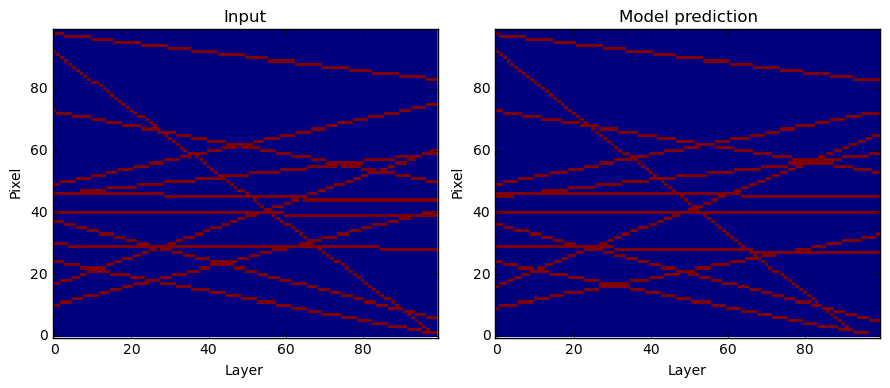

In [15]:
utils.make_pred_without_errors(pretrainable_model_1.track_pred_model, n_tracks=12, det_shape=det_shape)

It works about as well as before, but at the cost of much longer training time and higher model complexity.  This needs further development if we are going to use it.  